In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.misc

# Parameters



In [5]:
step_size=1. # starting step_size for gradient descent
min_step_size=step_size # updates the smallest step_size during training
no_of_pts = 50 # size of dataset
np.random.seed(11) # a random seed for reproducibility
dim_layer_1=2 # the size of the first hidden layer in the network
dim_in=2 # the input dimension

# Network design

A simple fully connected four-layer neural network with sigmoid activation function and with training procedure gradient descent with variable step_size assuring that the error never increases along the path. (Note that this is not a good training procedure if one wants to avoid suboptimal local minima.)

In [6]:
# Sigmoid activation function 
# its derivative is given by f'(x)=f(x)(1-f(x))
def activation(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1./(1+np.exp(-x))

In [7]:
# Construct network, which has two hidden layers of size 2-2-4-1, therefore we will have 4+8+4=16 weights starrting from network with 2-2-2-1 with 4+4+2=10 weights
def network_function(inputs,u,v,w):
    layer_1 =  activation(np.dot(inputs,u)) # (batch_size, dim_layer_1)
    layer_2 = activation(np.dot(layer_1,v)) # (batch_size, dim_layer_2)
    guess = np.dot(layer_2,w) # (batch_size, dim_out)
    return guess

def step_deep(inputs,labels,u,v,w,step_size,min_step_size):
    layer_1 =  activation(np.dot(inputs,u)) # (batch_size, dim_layer_1)
    layer_2 = activation(np.dot(layer_1,v)) # (batch_size, dim_layer_2)
    guess = np.dot(layer_2,w) # (batch_size, dim_out)
    delta_out = guess-labels # (batch_size, 1)
    delta_layer_2 = np.dot(delta_out,w.T)*activation(layer_2, deriv=True)
    delta_layer_1 = np.dot(delta_layer_2,v.T)*activation(layer_1, deriv=True)
    # (batch_size, dim_layer_1) = (batch_size,1).(1, dim_layer_1) * (batch_size, dim_layer_1)
    w_check = w -step_size*np.dot(layer_2.T, delta_out)
    v_check = v -step_size*np.dot(layer_1.T, delta_layer_2)
    u_check = u -step_size*np.dot(inputs.T, delta_layer_1)
    guess_check = np.dot(activation(np.dot(activation(np.dot(inputs,u_check)),v_check)),w_check)
    error = np.sum((guess-labels)**2)
    error_check = np.sum((guess_check-labels)**2)
    if error_check > error:
        step_size=step_size/2.
        if step_size < min_step_size and min_step_size<0.001:
            print(step_size)
            min_step_size=step_size
    else:
        u = u_check
        v = v_check
        w = w_check
        step_size=step_size*1.1
    return (u,v,w, guess, step_size,min_step_size)

# Plotting functions

### Plotting the neighborhood

plotFunction() returns two images. It samples no_directions many directions in parameter space and displays the error function into all (two-sided) directions from u,v,w in one plot. The second plot contains the minimal error over all paths.

Arguments:

u,v,w= parameters 

no_directions= the number of directions

no_path_pts= the number of sample points along each direction (on each side)

inputs, labels = the dataset

scale=a number to adjust the scale of the image around the starting point



In [8]:
def plotFunction(u,v,w,no_directions,no_path_pts,inputs,labels,scale):
    u_flat=u.flatten()
    v_flat=v.flatten()
    w_flat=w.flatten()
    variables=np.concatenate([u_flat,v_flat,w_flat])
    no_variables = variables.size
    
    directions = np.zeros(shape=(no_directions,no_variables))
    for i in range(no_directions):
        direction = 2*np.random.random(no_variables)-1.
        normalization = LA.norm(direction)
        try:
            directionUnit = direction/normalization
        except:
            directionUnit = direction
        directions[i,:]=directionUnit
    
    paths=np.zeros(shape=(no_directions, 2*no_path_pts, no_variables))
    for i in range(no_directions):
        for t in range(2*no_path_pts):
            paths[i,t,:]=variables + (-no_path_pts+t)/(no_path_pts-1)*directions[i,:]*scale

    
    error_paths = np.zeros([no_directions,2*no_path_pts])
    for i in range(no_directions):
        for t in range(2*no_path_pts):
            error_paths[i,t]=(np.sum((network_function(inputs,
                                         paths[i,t, 0:u_flat.size].reshape(u.shape),
                                         paths[i,t, u_flat.size:(u_flat.size+v_flat.size)].reshape(v.shape),
                                         paths[i,t,
                                               (u_flat.size+v_flat.size):].reshape(w.shape)
                                        )-labels)**2))       
    
    minPath = np.amin(error_paths,axis=0)
    
    x_axis=np.zeros(2*no_path_pts)
    for i in range(2*no_path_pts):
        x_axis[i]=(-no_path_pts+i)/(no_path_pts-1.)
    
   
    
    plt.figure(1) 
    plt.subplot(211)
    for t in range(no_directions):
        plt.plot(x_axis,error_paths[t,:])
    plt.xlabel('t')
    plt.ylabel("error")
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    plt.subplot(212)
    plt.plot(x_axis,minPath)
    plt.xlabel('t')
    plt.ylabel("error")
    
    plt.show
    
    
    return None

### Plotting into a specific direction

Shows the error function into a specific direction (both sides of the starting point)

Parameters:

u,v,w = starting parameters

direction = direction in parameter space to show the error function

no_path_pts = number of samples taking into the direction (on each side)

inputs, labels = the dataset

scale = a number to adjust the scale of the image around the starting point

In [9]:
def plotAlongDirection(u,v,w,direction,no_path_pts,inputs,labels,scale):
    u_flat=u.flatten()
    v_flat=v.flatten()
    w_flat=w.flatten()
    variables=np.concatenate([u_flat,v_flat,w_flat])
    no_variables = variables.size
       
    path=np.zeros(shape=(2*no_path_pts, no_variables))
    for t in range(2*no_path_pts):
        path[t,:]=variables + (-no_path_pts+t)/(no_path_pts-1)*direction*scale

    error_path = np.zeros(2*no_path_pts)
    for t in range(2*no_path_pts):
        error_path[t]=(np.sum((network_function(inputs,
                                                     path[t, 0:u_flat.size].reshape(u.shape),
                                                     path[t, u_flat.size:(u_flat.size+v_flat.size)].reshape(v.shape),
                                                     path[t,(u_flat.size+v_flat.size):].reshape(w.shape)
                                                    ) -labels)**2))       
    
    x_axis=np.zeros(2*no_path_pts)
    for i in range(2*no_path_pts):
        x_axis[i]=(-no_path_pts+i)/float(no_path_pts-1.)
    

    plt.plot(x_axis,error_path)
    plt.xlabel('t')
    plt.ylabel("error")            
    plt.show
    
    return None

# Define target function and dataset

In [10]:
# Initialze weights for layers randomly
u = 10*np.random.random((dim_in,dim_layer_1))-5 # (dim_in, dim_layer_1)
v = 10*np.random.random((dim_layer_1,4))-5  # (dim_layer_1, dim_layer_2)
w = 10*np.random.random((4,1))-5  # (dim_layer_2, dim_out)

In [11]:
# Choose input
inputs =np.random.random((no_of_pts,dim_in))

In [12]:
# Create labels
labels = network_function(inputs,u,v,w)

# Create smaller network by initializing new weights

In [13]:
# Construct network, which has two hidden layers of size indim=2-3-2-1, therefore we will have 6+6+2=14 weights
U = 10*np.random.random((dim_in,dim_layer_1))-5 # (dim_in, dim_layer_1)
V = 10*np.random.random((dim_layer_1,2))-5  # (dim_layer_1, dim_layer_2)
W = 10*np.random.random((2,1))-5  # (dim_layer_2, dim_out)

# Train the smaller network to match the dataset defined by the larger one

In [14]:
for j in range(1000000):
    (U,V,W,guess,step_size, min_step_size) = step_deep(inputs,labels,U,V,W,step_size, min_step_size)

In [15]:
error =  np.sum((guess - labels)**2)
print("Error= "+str(error)+"\n u="+str(U)+"\n v="+str(V)+"\n w="+str(W)+"\n step size="+str(step_size))

Error= 0.012730804455538706
 u=[[-2.89665447  4.7817757 ]
 [-0.18237943 -3.46023762]]
 v=[[-0.51539652  3.67607446]
 [ 5.74365055 -1.33803017]]
 w=[[1.49513378]
 [5.82758046]]
 step size=0.017160963635285242


In [16]:
step_size=1.
min_step_size=step_size
for j in range(1000000):
    (U,V,W,guess,step_size,min_step_size) = step_deep(inputs,labels,U,V,W,step_size,min_step_size)

In [17]:
error = np.sum((guess - labels)**2)
print("Error= "+str(error)+"\n u="+str(U)+"\n v="+str(V)+"\n w="+str(W)+"\n step size="+str(step_size))

Error= 0.012729967428797173
 u=[[-2.90625784  4.7869507 ]
 [-0.17855168 -3.46363028]]
 v=[[-0.54968784  3.66510279]
 [ 5.78377589 -1.32599466]]
 w=[[1.48009098]
 [5.84516084]]
 step size=0.017160963635285242


In [18]:
step_size=1.
for j in range(1000000):
    (U,V,W,guess,step_size,min_step_size) = step_deep(inputs,labels,U,V,W,step_size,min_step_size)

In [19]:
error = np.sum((guess - labels)**2)
print("Error= "+str(error)+"\n u="+str(U)+"\n v="+str(V)+"\n w="+str(W)+"\n step size="+str(step_size))

Error= 0.01272996724937215
 u=[[-2.90634122  4.78699525]
 [-0.17851842 -3.46366005]]
 v=[[-0.54998944  3.66500776]
 [ 5.78412938 -1.32589009]]
 w=[[1.47995947]
 [5.84531431]]
 step size=5.026233876321318e-10


## Some tricks and more learning to increase the chances to get close enough to a local minimum
### Analytically solving for the optimal W given U and V

In [20]:
A= activation(np.dot(activation(np.dot(inputs,U)),V))
try:
    W=np.matmul(np.linalg.inv(np.matmul(np.transpose(A),A)),np.matmul(np.transpose(A),labels))
except:
    pass
W

array([[1.47995946],
       [5.84531432]])

In [21]:
for j in range(100000):
    (U,V,W,guess,step_size,min_step_size) = step_deep(inputs,labels,U,V,W,step_size,min_step_size)

In [22]:
A= activation(np.dot(activation(np.dot(inputs,U)),V))
try:
    W=np.matmul(np.linalg.inv(np.matmul(np.transpose(A),A)),np.matmul(np.transpose(A),labels))
except:
    pass
W

array([[1.47995946],
       [5.84531432]])

In [23]:
for j in range(1000000):
    (U,V,W,guess,step_size,min_step_size) = step_deep(inputs,labels,U,V,W,step_size,min_step_size)

In [24]:
error = np.sum((guess - labels)**2)
print("Error= "+str(error)+"\n u="+str(U)+"\n v="+str(V)+"\n w="+str(W)+"\n step size="+str(step_size))

Error= 0.012729967249371418
 u=[[-2.90634122  4.78699525]
 [-0.17851842 -3.46366005]]
 v=[[-0.54998944  3.66500776]
 [ 5.78412938 -1.32589009]]
 w=[[1.47995946]
 [5.84531432]]
 step size=5.141002460877321e-10


# Checking partial derivatives of the loss function after training

### The partial derivatives of the loss function with respect to parameters U,V and W (sum over directions for each layer)

In [25]:
def error_U(uu):
    guess = network_function(inputs,uu,V,W)
    return np.sum((guess - labels)**2)
def error_V(vv):
    guess = network_function(inputs,U,vv,W)
    return np.sum((guess - labels)**2)
def error_W(ww):
    guess = network_function(inputs,U,V,ww)
    return np.sum((guess - labels)**2)

In [26]:
scipy.misc.derivative(error_U,U,dx=1e-6),scipy.misc.derivative(error_V,V,dx=1e-6),scipy.misc.derivative(error_W,W,dx=1e-6)

(7.561225950913908e-08, -9.842127113302013e-08, -1.9081958235744878e-11)

### We also compute the partial derivatives of the function itself (mean over directions for each layer). Note that these are nonzero in contrast to the partial derivatives of the loss function.

In [27]:
def n_U(uu):
    return np.mean(network_function(inputs, uu, V, W))
def n_V(vv):
    return np.mean(network_function(inputs, U, vv, W))
def n_W(ww):
    return np.mean(network_function(inputs, U, V, ww))


In [28]:
scipy.misc.derivative(n_U,U,dx=1e-6),scipy.misc.derivative(n_V,V,dx=1e-6),scipy.misc.derivative(n_W,W,dx=1e-6)

(0.3832512178725267, 1.084214943158912, 1.4123512865893417)

# Check the necessary condition of positive definiteness of matrix B to add a neuron to the last hidden layer using its first neuron

In [29]:
layer_1 = activation(np.dot(inputs,U)) # (batch_size, dim_layer_1)
layer_2 = activation(np.dot(layer_1,V)) #(batch_size, dim_layer_2)
dh_by_dn = np.ones(no_of_pts).reshape([no_of_pts,1,1]) 
sigma_double_prime = (layer_2[:,0] - 3*layer_2[:,0]**2+2*layer_2[:,0]**3)
summands=(((guess-labels)*(np.dot(dh_by_dn,W[0])))*sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(layer_1.reshape(no_of_pts,1,dim_layer_1)*layer_1.reshape(no_of_pts,dim_layer_1,1))
B = np.sum(summands,0)
B

array([[0.00013482, 0.00021508],
       [0.00021508, 0.00038006]])

In [30]:
eigenValues = np.linalg.eig(B)[0]
eigenValues

array([9.86473423e-06, 5.05016000e-04])

In [31]:
definiteness = "B is "
if all(i > 0 for i in eigenValues):
    definiteness+="positive definite"
elif all(i < 0 for i in eigenValues):
    definiteness+="negative definite"
else:
    definiteness+="neither positive nor negative definite."
definiteness

'B is positive definite'

# Verify theory that when using the last hidden layer, the matrix D is zero, which is also a necessary condition for finding a local minimum.

In [32]:
np.sum((guess-labels).reshape(no_of_pts,1,1)*dh_by_dn*((layer_2[:,0]*(1-layer_2[:,0])).reshape(no_of_pts,1,1))*(layer_1.reshape(no_of_pts,dim_layer_1,1)),0)

array([[ 4.71930028e-08],
       [-4.67393056e-08]])

### We check also that D equals the partial derivatives up to factors given by parameters W

In [33]:
np.sum((guess-labels).reshape(no_of_pts,1,1)*dh_by_dn*((layer_2[:,0]*(1-layer_2[:,0])).reshape(no_of_pts,1,1))*(layer_1.reshape(no_of_pts,dim_layer_1,1)),0)/W-scipy.misc.derivative(error_V,V,dx=1e-6)

array([[1.30309309e-07],
       [9.04252417e-08]])

# We add one neuron to the last hidden layer

In [34]:
V_new = np.concatenate([V[:,0].reshape(dim_layer_1,1),V],axis=1)
V_new

array([[-0.54998944, -0.54998944,  3.66500776],
       [ 5.78412938,  5.78412938, -1.32589009]])

In [35]:
W_new=np.concatenate([W[0,:].reshape(1,1),W], axis = 0)*np.array([[1/3],[2/3],[1]])
W_new

array([[0.49331982],
       [0.98663964],
       [5.84531432]])

In [36]:
U_new=U

# Plot the neighbourhood of the point to verify it is a local minimum

#### First we check the point in original network (before adding one neuron)

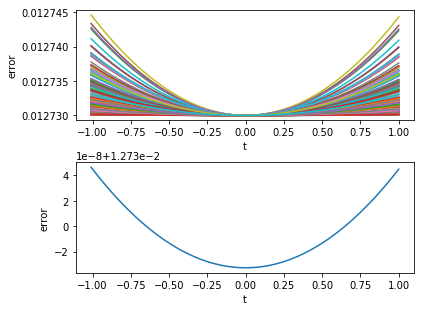

In [37]:
plotFunction(U,V,W,200,100,inputs,labels,0.0005)

### Now for the larger network

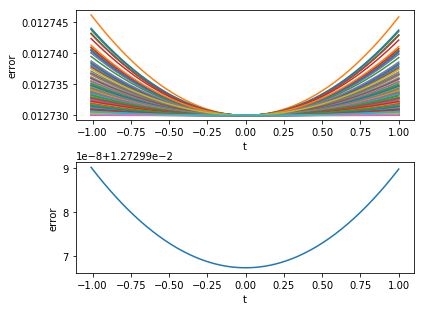

In [38]:
plotFunction(U_new,V_new,W_new,200,100,inputs,labels,0.0005)

# Now we change to a saddle point in the larger network (of the same loss value) and check it's neighbourhood. 

### Unfortunately, we have no luck in randomly finding a direction of descent like this. This shows that the critical point is still very close to being a local minimum. Below we will verify that the point is indeed a saddle point, by taking advantage of the direction of descent that the theoretical considerations suggest.

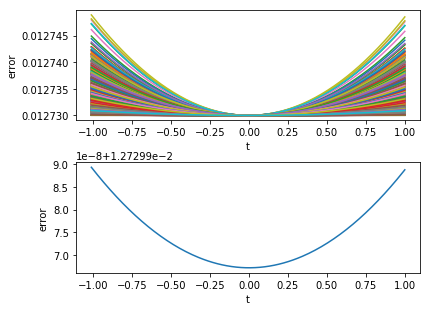

In [39]:
U_saddle = U_new
V_saddle = V_new
# W_saddle  = np.concatenate([W[0,:].reshape(1,1),W], axis = 0)*np.array([[4/3],[4/3],[1]])
W_saddle=W_new*np.array([[-3.],[3.],[1.]])
plotFunction(U_saddle,V_saddle,W_saddle,1000,100,inputs,labels,0.0005)

## We verify the degenerate direction in which the loss does not change and which allows to move from a local minimum to a saddle point

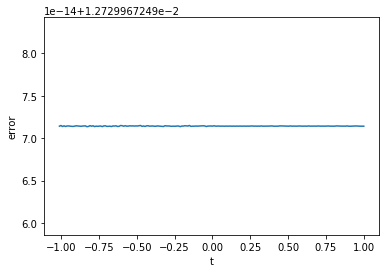

In [40]:
direction_U_degenerate=np.zeros(U_new.flatten().shape)
direction_V_degenerate = np.zeros(V_new.flatten().shape)
direction_W_degenerate=np.concatenate([W[0,:],-W[0,:],np.zeros( ( W_new[2:,:].flatten()).shape) ])

direction_degenerate = np.concatenate([direction_U_degenerate, direction_V_degenerate, direction_W_degenerate])


plotAlongDirection(U_new,V_new,W_new,direction_degenerate,100,inputs,labels,0.1)


# We verify that we can indeed reach a saddle point by such a path of nondegeneracy

For the saddle point from above, we used $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta,0)=(2,1,0)$ for V

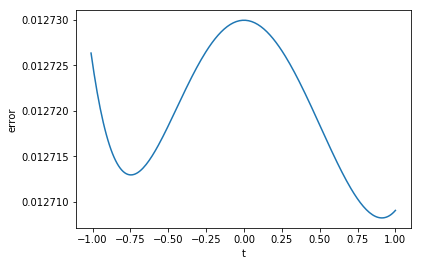

In [41]:
direction_U_saddle=np.zeros(U_saddle.flatten().shape)
direction_V_saddle = np.concatenate([2*V_saddle[:,0:1],V_saddle[:,0:1],np.zeros( (V_saddle[:,2:]).shape ) ],axis=1).flatten()
direction_W_saddle= np.zeros(W_saddle.flatten().shape)

direction_saddle=np.concatenate([direction_U_saddle, direction_V_saddle, direction_W_saddle] )

plotAlongDirection(U_saddle,V_saddle,W_saddle,direction_saddle,100,inputs,labels,0.05)


Note that we do indeed reach points with loss lower than 0.012729 along this direction.

## We add several (four) neurons in the above way, go through the same steps and get the same results. The neural network we get is larger than the one we constructed the dataset with and theoretically can attain zero loss.

In [42]:
V_large = np.concatenate([V[:,0].reshape(dim_layer_1,1),V[:,0].reshape(dim_layer_1,1),V[:,0].reshape(dim_layer_1,1),V],axis=1)
V_large

array([[-0.54998944, -0.54998944, -0.54998944, -0.54998944,  3.66500776],
       [ 5.78412938,  5.78412938,  5.78412938,  5.78412938, -1.32589009]])

In [43]:
W_large=np.concatenate([W[0,:].reshape(1,1),W[0,:].reshape(1,1),W[0,:].reshape(1,1),W], axis = 0)*np.array([[4./27.],[2./9.],[1./3.],[8./27.],[1.]])
W_large

array([[0.21925325],
       [0.32887988],
       [0.49331982],
       [0.43850651],
       [5.84531432]])

In [44]:
U_large=U

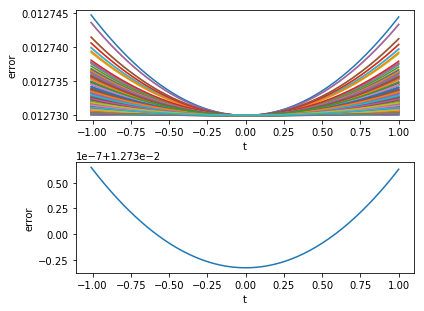

In [45]:
plotFunction(U,V,W,200,100,inputs,labels,0.0005)

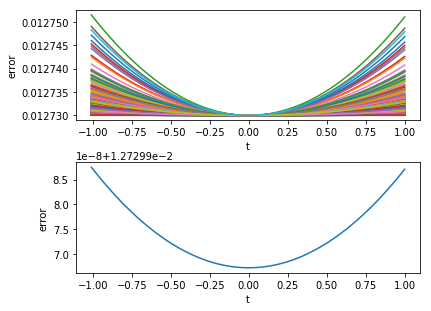

In [46]:
plotFunction(U_large,V_large,W_large,200,100,inputs,labels,0.0005)

array([[0.21925325],
       [0.32887988],
       [0.49331982],
       [0.43850651],
       [5.84531432]])

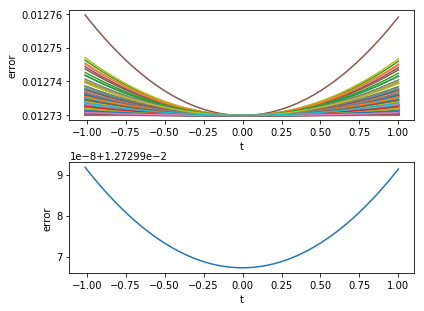

In [47]:
U_saddle_large = U_large
V_saddle_large = V_large
# W_saddle  = np.concatenate([W[0,:].reshape(1,1),W], axis = 0)*np.array([[4/3],[4/3],[1]])
W_saddle_large=W_large*np.array([[-3.],[1.],[1.],[3.],[1.]])
plotFunction(U_saddle_large,V_saddle_large,W_saddle_large,200,100,inputs,labels,0.0005)
W_large

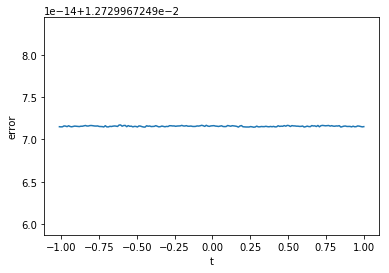

In [48]:
direction_U_large_degenerate=np.zeros(U_large.flatten().shape)
direction_V_large_degenerate = np.zeros(V_large.flatten().shape)
direction_W_large_degenerate=np.concatenate([W[0,:],np.zeros( ( W_large[1:3,:].flatten()).shape), -W[0,:], np.zeros( ( W_large[4:,:].flatten()).shape) ])

direction_large_degenerate = np.concatenate([direction_U_large_degenerate, direction_V_large_degenerate, direction_W_large_degenerate])


plotAlongDirection(U_large,V_large,W_large,direction_large_degenerate,100,inputs,labels,0.1)


At the saddle, we have $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta)=(2,1)$

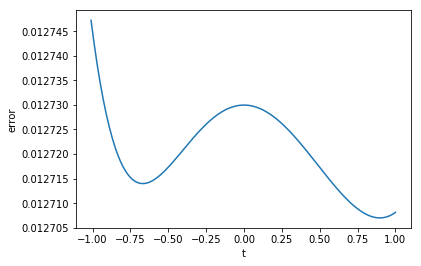

In [49]:
direction_U_large_saddle=np.zeros(U_saddle_large.flatten().shape)
direction_V_large_saddle = np.concatenate([2*V_saddle_large[:,0:1],np.zeros( (V_saddle_large[:,1:3]).shape ),V_saddle_large[:,0:1],np.zeros( (V_saddle_large[:,4:]).shape ) ],axis=1).flatten()
direction_W_large_saddle= np.zeros(W_saddle_large.flatten().shape)

direction_large_saddle=np.concatenate([direction_U_large_saddle, direction_V_large_saddle, direction_W_large_saddle] )

plotAlongDirection(U_saddle_large,V_saddle_large,W_saddle_large,direction_large_saddle,100,inputs,labels,0.08)


# We increase the network to eleven added neurons

In [178]:
V_eleven = np.concatenate([V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V[:,0].reshape(dim_layer_1,1),
                          V],axis=1)
V_eleven

array([[-0.54998944, -0.54998944, -0.54998944, -0.54998944, -0.54998944,
        -0.54998944, -0.54998944, -0.54998944, -0.54998944, -0.54998944,
        -0.54998944, -0.54998944,  3.66500776],
       [ 5.78412938,  5.78412938,  5.78412938,  5.78412938,  5.78412938,
         5.78412938,  5.78412938,  5.78412938,  5.78412938,  5.78412938,
         5.78412938,  5.78412938, -1.32589009]])

In [180]:
W_eleven=np.concatenate([W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W[0,:].reshape(1,1),
                        W], axis = 0)*np.array([[2.**10/(3.**11)],
                                                [2.**9/(3.**10)],
                                                [2.**8/(3.**9)],
                                                [2.**7/(3.**8)],
                                                [2.**6/(3.**7)],
                                                [2.**5/(3.**6)],
                                                [2.**4/(3.**5)],
                                                [8./(3.**4)],
                                                [4./27.],
                                                [2./9.],
                                                [1./3.],
                                                [2.**11/(3.**11)],
                                                [1.]])
W_eleven

array([[0.00855492],
       [0.01283238],
       [0.01924857],
       [0.02887286],
       [0.04330928],
       [0.06496393],
       [0.09744589],
       [0.14616884],
       [0.21925325],
       [0.32887988],
       [0.49331982],
       [0.01710984],
       [5.84531432]])

In [176]:
no_hidden_neurons = 50

In [182]:
U_eleven=U

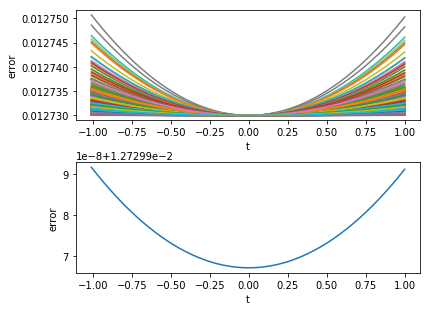

In [184]:
plotFunction(U_eleven,V_eleven,W_eleven,200,100,inputs,labels,0.0005)

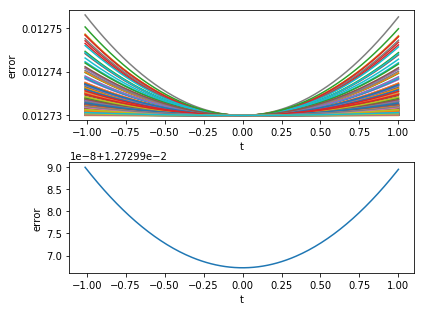

In [186]:
U_saddle_eleven = U_eleven
V_saddle_eleven = V_eleven
# W_saddle  = np.concatenate([W[0,:].reshape(1,1),W], axis = 0)*np.array([[4/3],[4/3],[1]])
W_saddle_eleven=W_eleven*np.array([[-3.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [1.],
                                 [3.],
                                 [1.]])
plotFunction(U_saddle_eleven,V_saddle_eleven,W_saddle_eleven,200,100,inputs,labels,0.0005)

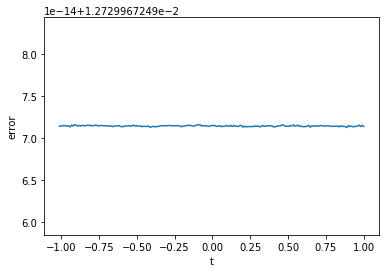

In [188]:
direction_U_eleven_degenerate=np.zeros(U_eleven.flatten().shape)
direction_V_eleven_degenerate = np.zeros(V_eleven.flatten().shape)
direction_W_eleven_degenerate=np.concatenate([W[0,:],np.zeros( ( W_eleven[1:11,:].flatten()).shape), -W[0,:], np.zeros( ( W_eleven[12:,:].flatten()).shape) ])

direction_eleven_degenerate = np.concatenate([direction_U_eleven_degenerate, direction_V_eleven_degenerate, direction_W_eleven_degenerate])


plotAlongDirection(U_eleven,V_eleven,W_eleven,direction_eleven_degenerate,100,inputs,labels,0.1)


At the saddle, we have $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta)=(2,1)$

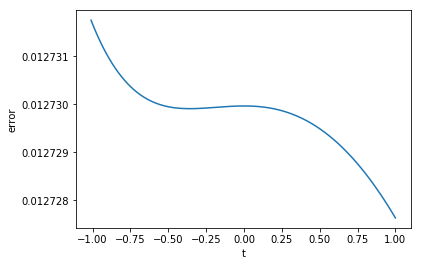

In [207]:
direction_U_eleven_saddle=np.zeros(U_saddle_eleven.flatten().shape)
direction_V_eleven_saddle = np.concatenate([2*V_saddle_eleven[:,0:1],np.zeros( (V_saddle_eleven[:,1:3]).shape ),V_saddle_eleven[:,0:1],np.zeros( (V_saddle_eleven[:,4:]).shape ) ],axis=1).flatten()
direction_W_eleven_saddle= np.zeros(W_saddle_eleven.flatten().shape)

direction_eleven_saddle=np.concatenate([direction_U_eleven_saddle, direction_V_eleven_saddle, direction_W_eleven_saddle] )

plotAlongDirection(U_saddle_eleven,V_saddle_eleven,W_saddle_eleven,direction_eleven_saddle,100,inputs,labels,0.1)


# We make the last hidden layer arbitrarily big and show that it still leads to a suboptimal local minimum

In [177]:
V_tile = np.tile(V[:,0].reshape(dim_layer_1,1),(1,no_hidden_neurons-2))
V_huge = np.concatenate([V_tile,V],axis=1)



In [179]:
W_tile = np.tile(W[0,:].reshape(1,1),(no_hidden_neurons-2,1))

lambdas = np.zeros(shape=(no_hidden_neurons,1))
lambdas[-1,:]=1.
lambdas[-2,:]=2**(no_hidden_neurons-2)/3.**(no_hidden_neurons-2)

for i in range(no_hidden_neurons-2):
    lambdas[-i-3,:]=2.**i/3.**(i+1)
    
W_huge=np.concatenate([W_tile,W],axis=0)* lambdas

In [181]:
U_huge=U

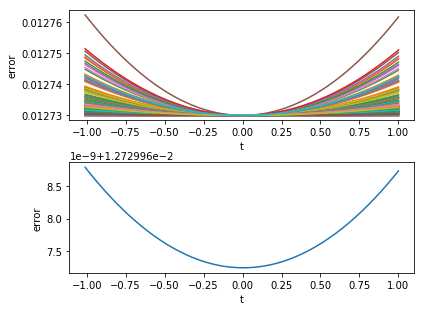

In [183]:
plotFunction(U_huge,V_huge,W_huge,200,100,inputs,labels,0.0005)

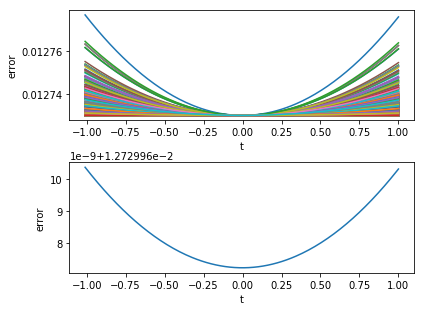

In [185]:
U_saddle_huge = U_huge
V_saddle_huge = V_huge
# W_saddle  = np.concatenate([W[0,:].reshape(1,1),W], axis = 0)*np.array([[4/3],[4/3],[1]])

lambdas_saddle=np.ones(shape=(no_hidden_neurons,1))
lambdas_saddle[0,0]=-3.
lambdas_saddle[-2,0]=3.
W_saddle_huge=W_huge*lambdas_saddle

plotFunction(U_saddle_huge,V_saddle_huge,W_saddle_huge,1000,100,inputs,labels,0.0005)

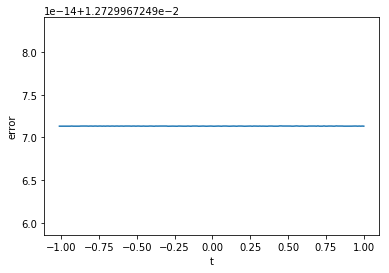

In [187]:
direction_U_huge_degenerate=np.zeros(U_huge.flatten().shape)
direction_V_huge_degenerate = np.zeros(V_huge.flatten().shape)
direction_W_huge_degenerate=np.concatenate([W[0,:],np.zeros( shape= (no_hidden_neurons-3,)), -W[0,:], np.zeros( shape=(1,))])

direction_huge_degenerate = np.concatenate([direction_U_huge_degenerate, direction_V_huge_degenerate, direction_W_huge_degenerate])


plotAlongDirection(U_huge,V_huge,W_huge,direction_huge_degenerate,100,inputs,labels,0.1)


At the saddle, we have $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta)=(2,1)$

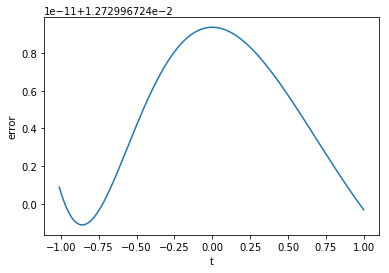

In [229]:
direction_U_huge_saddle=np.zeros(U_saddle_huge.flatten().shape)
direction_V_huge_saddle = np.concatenate([2*V_saddle_huge[:,0:1],np.zeros( (V_saddle_huge[:,1:no_hidden_neurons-2]).shape ),V_saddle_huge[:,0:1],np.zeros( shape=(2,1) ) ],axis=1).flatten()
direction_W_huge_saddle= np.zeros(W_saddle_huge.flatten().shape)

direction_huge_saddle=np.concatenate([direction_U_huge_saddle, direction_V_huge_saddle, direction_W_huge_saddle] )

plotAlongDirection(U_saddle_huge,V_saddle_huge,W_saddle_huge,direction_huge_saddle,100,inputs,labels,0.4)


# We verify the local minimum point by further training via gradient descent

In [193]:
step_size=0.01
min_step_size=step_size
U_huge_new=U_huge
V_huge_new=V_huge
W_huge_new=W_huge

for j in range(1000000):
    (U_huge_new,V_huge_new,W_huge_new,guess,step_size,min_step_size) = step_deep(inputs,labels,U_huge_new,V_huge_new,W_huge_new,step_size,min_step_size)

In [194]:
error = np.sum((guess - labels)**2)
print("Error= "+str(error)+"\n u="+str(U_huge_new)+"\n v="+str(V_huge_new)+"\n w="+str(W_huge_new))

Error= 0.012729967249371317
 u=[[-2.90634122  4.78699525]
 [-0.17851842 -3.46366005]]
 v=[[-0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944 -0.54998944
  -0.54998944  3.66500776]
 [ 5.78412938  5.78412938  5.78412938  5.78412938  5.78412938  5.78412938
   5.78412938  5.78412938  5.78412938  5.78412938  5.78412938  5.78412938
   5.78412938  5.78412938  5.78412938  5.78412938  5.78412938  5.78412938
   5.78412938  5.78412938  5.78412938  5.78412938  5.78412938  5.78412

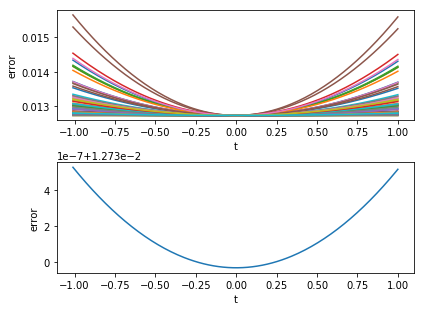

In [195]:
plotFunction(U_huge_new,V_huge_new,W_huge_new,100,100,inputs,labels,0.005)